Pedro Martelleto Bressane Rezende - Oct. 18, 2022

Test Task - Medical Ultrasound Images for Breast Cancer Classification

TU Kaiserslautern - Project AAI WS 2022/23

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.rand(10).to(device)
torch.rand(10, device=device)

tensor([0.6130, 0.0101, 0.3984, 0.0403, 0.1563, 0.4825, 0.7362, 0.4060, 0.5189,
        0.2867], device='cuda:0')

# Dataset downloading (upload a kaggle.json API key)

In [ ]:
# Please select a kaggle API key to get the dataset from kaggle
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pedromartelleto","key":"6f5120f8e731d4ded5ac7bbce6175a4f"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                      9KB  2022-10-06 08:55:25           4754        152  1.0              
vittoriogiatti/bigmacprice                                      Bigmac Prices                                        14KB  2022-10-19 21:11:14            951         27  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset               11KB  2022-09-30 04:05:11           3938        115  1.0              


In [ ]:
!kaggle datasets download aryashah2k/breast-ultrasound-images-dataset

 87% 169M/195M [00:08<00:01, 18.5MB/s]
100% 195M/195M [00:08<00:00, 23.8MB/s]


In [ ]:
!unzip breast-ultrasound-images-dataset.zip

Archive:  breast-ultrasound-images-dataset.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104)_mask.png  
  inflating: Data

In [ ]:
# We won't be using the masks, so move them to another folder
!mkdir Dataset_MASKS
!mkdir Dataset_MASKS/benign
!mkdir Dataset_MASKS/malignant
!mkdir Dataset_MASKS/normal
!mv Dataset_BUSI_with_GT/benign/*mask* Dataset_MASKS/benign/
!mv Dataset_BUSI_with_GT/malignant/*mask* Dataset_MASKS/malignant
!mv Dataset_BUSI_with_GT/normal/*mask* Dataset_MASKS/normal

mkdir: cannot create directory ‘Dataset_MASKS’: File exists
mkdir: cannot create directory ‘Dataset_MASKS/benign’: File exists
mkdir: cannot create directory ‘Dataset_MASKS/malignant’: File exists
mkdir: cannot create directory ‘Dataset_MASKS/normal’: File exists


# Hyperparameters and settings

In [ ]:
# Config
DS_PATH = "Dataset_BUSI_with_GT"
CLASS_NAMES = [ 'benign', 'malignant', 'normal' ]
SEED = 42
TRAIN_SPLIT = 0.8 # val split is the rest

# Because we are fine-tuning from ImageNet...
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

# Hyperparameters
BATCH_SIZE = 64

# Loading the data + Data augmentation

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import glob
import os
import time
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import plotly.express as px

In [ ]:
# Ensures there is a GPU available for training and setups a seed
print("GPU Available? " + ("Yes" if torch.cuda.is_available() else "No"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)

GPU Available? Yes


In [ ]:
import cv2

# Helper class for data augmentation
class AugDataset(datasets.ImageFolder):
  def __init__(self, root, aug, *args, **kwargs):
    super(AugDataset, self).__init__(root, *args, **kwargs)
    self.aug = aug

  def __getitem__(self, idx):
    image, label = super(AugDataset, self).__getitem__(idx)

    if self.aug:
        augmented = self.aug(image=np.array(image.convert('RGB')))
        image = augmented['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float)

    return image, label

In [ ]:
import albumentations as A

# Defines a transform to run over the images loaded from the kaggle dataset
# Also computes the size of the training and validation set

transform = transforms.Compose([ transforms.CenterCrop(224),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=NORM_MEAN, std=NORM_STD) ])

# Data augmentation pipeline
aug = A.Compose([ A.RandomRotate90(),
                  A.Transpose(),
                  A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
                  A.Blur(blur_limit=2.2),
                  A.PadIfNeeded(224, 224),
                  A.RandomCrop(width=224, height=224),
                  A.Normalize(mean=NORM_MEAN, std=NORM_STD) ])

aug_dataset = AugDataset('Dataset_BUSI_with_GT/', aug=aug)
dataset = AugDataset('Dataset_BUSI_with_GT/', aug=None, transform=transform)
train_count = int(float(len(dataset.imgs)) * TRAIN_SPLIT)
val_count = len(dataset.imgs) - train_count

gen = torch.Generator()
gen.manual_seed(0)
aug_ds_train, aug_ds_val = torch.utils.data.random_split(aug_dataset, [train_count, val_count])

gen = torch.Generator()
gen.manual_seed(0)
ds_train, ds_val = torch.utils.data.random_split(dataset, [train_count, val_count])

In [ ]:
# We are not using the masks currently, so it is important to ensure no masks were left in the dataset

# Important: Asserts no masks are left!
for (sample_name, _) in dataset.samples:
  assert 'mask' not in os.path.basename(sample_name)

In [ ]:
# Setups data loaders for our dataset

train_loader = torch.utils.data.DataLoader(aug_ds_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}
ds_sizes = {
    'train': len(ds_train),
    'val': len(ds_val)
}

# Dataset preview

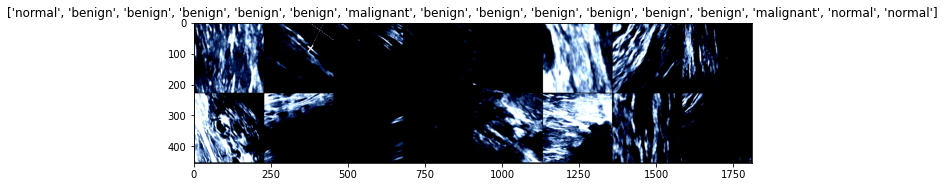

In [ ]:
# Preview of the dataset

def imshow(input, title=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(np.clip(input.numpy().transpose((1, 2, 0)), 0, 1))
    if title is not None: plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs[0:16])
imshow(out, title=[CLASS_NAMES[x] for x in classes[0:16]])

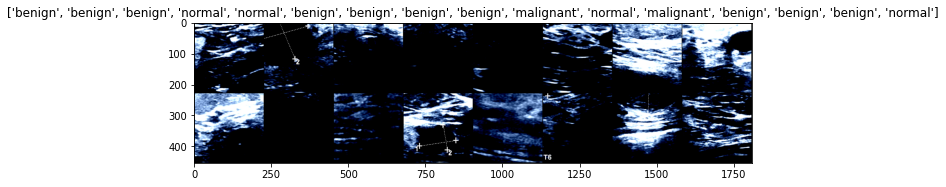

In [ ]:
# Preview of the dataset

def imshow(input, title=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(np.clip(input.numpy().transpose((1, 2, 0)), 0, 1))
    if title is not None: plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs[0:16])
imshow(out, title=[CLASS_NAMES[x] for x in classes[0:16]])

# Training

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

4818

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Helper class that encapsulates training logic
class Trainer:
  def __init__(self, model, loss_fn, optimizer, scheduler, num_epochs=25):
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.num_epochs = num_epochs

  # One optimization/validation step that takes in batches from the data
  def optimizer_step(self, phase, inputs, labels):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Resets gradients
    self.optimizer.zero_grad()
    with torch.set_grad_enabled(phase == 'train'):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)

        # Backprop only in the training stage
        if phase == 'train':
            loss.backward()
            self.optimizer.step()

    # Computes useful statistics
    self.running_loss += loss.item() * inputs.size(0)
    self.running_corrects += torch.sum(preds == labels.data)

  # The main function of this class. Call this to train self.model with the
  # specified optimizer, loss_fn, num_epochs and learning rate scheduler
  def train(self):
      since = time.time()

      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0

      for epoch in range(self.num_epochs):
          print(f'Epoch {epoch}/{self.num_epochs - 1}')
          print('-' * 10)

          for phase in ['train', 'val']:
              if phase == 'train':
                  model.train()  # Set model to training mode
              else:
                  model.eval()   # Set model to evaluate mode

              self.running_loss = 0.0
              self.running_corrects = 0

              # Iterate over data
              for inputs, labels in dataloaders[phase]:
                  self.optimizer_step(phase, inputs, labels)
              
              if phase == 'train':
                  # We only want to update the learning rate scheduler during training
                  self.scheduler.step()

              # Computes statistics
              epoch_loss = self.running_loss / ds_sizes[phase]
              epoch_acc = self.running_corrects.double() / ds_sizes[phase]

              print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

              # The best weights are the ones if the biggest validation accuracy
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())

          print()

      # More statistics
      time_elapsed = time.time() - since
      print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
      print(f'Best val Acc: {best_acc:4f}')

      # Load the best weights before returning
      model.load_state_dict(best_model_wts)

      return model

# Actually defines the model for transfer learning
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)

# Defines loss, optimizer, scheduler...
loss_fn = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Trains the model!
model = Trainer(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=45).train()

Epoch 0/44
----------
train Loss: 0.9664 Acc: 0.5801
val Loss: 9.3357 Acc: 0.5449

Epoch 1/44
----------
train Loss: 0.9486 Acc: 0.6026
val Loss: 9.3286 Acc: 0.3590

Epoch 2/44
----------
train Loss: 0.9150 Acc: 0.5865
val Loss: 1.3157 Acc: 0.5513

Epoch 3/44
----------
train Loss: 0.9133 Acc: 0.5978
val Loss: 1.1359 Acc: 0.4872

Epoch 4/44
----------
train Loss: 0.8855 Acc: 0.6090
val Loss: 1.1945 Acc: 0.6154

Epoch 5/44
----------
train Loss: 0.9169 Acc: 0.6026
val Loss: 1.0376 Acc: 0.5064

Epoch 6/44
----------
train Loss: 0.8949 Acc: 0.6106
val Loss: 0.8430 Acc: 0.6795

Epoch 7/44
----------
train Loss: 0.8444 Acc: 0.6250
val Loss: 0.7897 Acc: 0.6474

Epoch 8/44
----------
train Loss: 0.8506 Acc: 0.6266
val Loss: 0.7809 Acc: 0.6346

Epoch 9/44
----------
train Loss: 0.8323 Acc: 0.6282
val Loss: 0.7479 Acc: 0.6282

Epoch 10/44
----------
train Loss: 0.7926 Acc: 0.6394
val Loss: 0.7396 Acc: 0.6154

Epoch 11/44
----------
train Loss: 0.7944 Acc: 0.6378
val Loss: 0.7331 Acc: 0.6346

Ep

# Model summary 

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Feature extraction

In [ ]:
from torchvision.models import feature_extraction

features_model = feature_extraction.create_feature_extractor(model, {'avgpool': 'feats'})
features_model.eval()

no_aug_dataloaders = {
    'train': torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True),
    'val': torch.utils.data.DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True)
}

def get_features_and_labels(phase):
  for inputs, labels in no_aug_dataloaders[phase]:
    inputs = inputs.to(device)
    features.append(features_model(inputs)['feats'].detach().cpu().numpy())
    feature_labels.append(labels.numpy().reshape(-1,1))
  
  return features, feature_labels

features = list()
feature_labels = list()

train_feat, train_feat_labels = get_features_and_labels('train')
features.extend(train_feat)
feature_labels.extend(train_feat_labels)

val_feat, val_feat_labels = get_features_and_labels('val')
features.extend(val_feat)
feature_labels.extend(val_feat_labels)

features = np.vstack(features)
feature_labels = np.vstack(feature_labels).reshape(-1)

# T-SNE + Plotly for visualization

In [ ]:
scaled_feat = MinMaxScaler().fit_transform(features.reshape(features.shape[0], -1))

In [ ]:
features_embedded_2d = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(scaled_feat)

feats_with_labels = np.c_[ np.asarray(features_embedded_2d), feature_labels ]

df = pd.DataFrame(columns=['f1', 'f2', 'label'], data=feats_with_labels)

fig = px.scatter(df, x='f1', y='f2', color='label')
fig.show()

In [ ]:
features_embedded_3d = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(scaled_feat)

feats_with_labels = np.c_[ np.asarray(features_embedded_3d), feature_labels ]

df = pd.DataFrame(columns=['f1', 'f2', 'f3', 'label'], data=feats_with_labels)

fig = px.scatter_3d(df, x='f1', y='f2', z='f3', color='label')
fig.write_html("results.html")
fig.show()